# Load Modules

In [2]:
# Modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import (confusion_matrix, auc, classification_report, dcg_score, f1_score, precision_recall_curve,\
                             precision_score, recall_score, roc_auc_score, roc_curve)
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb

import pycaret
import pandas_profiling
import matplotlib.pyplot as plt
import itertools

import pickle
import joblib
import math
import os

from pygam import LogisticGAM, s, f
import warnings
warnings.filterwarnings('ignore')

In [3]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=[0,1], title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True, title='Normalized confusion matrix')
    plt.show()

def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    # fi to dataframe
#     df = pd.DataFrame(data=[model.feature_importances_, model.feature_name_], index=['importance','feature']).T
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [4]:
def classification_result(df, y_true, y_pred):
    conditionlist = [
        (df['y_true']==1) & (df['y_pred']==1),
        (df['y_true']==0) & (df['y_pred']==0),
        (df['y_true']==0) & (df['y_pred']==1),
        (df['y_true']==1) & (df['y_pred']==0)]
    
    choicelist = ['TP', 'TN', 'FP', 'FN']
    
    df['class'] = np.select(conditionlist, choicelist, default='Not Specified')
    
    return df

In [5]:
print(os.listdir('../../../data/santander/raw//'))

['test.csv', 'original_train.pickle', 'train.csv', 'original_test.pickle']


# Load Data

In [6]:
# path = '../Digitallab_Project/what_if/data/santander'
path = '../../../data/santander'
df_train = pd.read_csv(path + '/raw/train.csv')
# df_test = pd.read_pickle(path + '/raw/original_test.pickle')

# df_train_proc = pd.read_pickle(path + '/raw/processed_train_hj.pickle')

In [7]:
df_train.shape

(200000, 202)

In [8]:
df_train.sample(3)

ID_code  target    var_0   var_1    var_2   var_3    var_4  \
183784  train_183784       0  14.3649  1.7656   7.7547  7.8861   8.9279   
196425  train_196425       0  11.5662  3.0969  13.0686  2.9714  13.3510   
29080    train_29080       0  10.7279  2.2537  13.4639  9.7265  11.2930   

          var_5   var_6    var_7  ...  var_190  var_191  var_192  var_193  \
183784   0.7549  4.6152  19.0763  ...   9.4905  10.3304   0.2259   4.6549   
196425  -6.3086  5.6765  11.6304  ...   9.1269  11.5064   2.8880   8.2222   
29080  -10.5033  4.4577  17.6054  ...   3.6239   7.7068   0.4990   6.4379   

        var_194  var_195  var_196  var_197  var_198  var_199  
183784  21.0160  -1.6070   5.7361   8.9416  12.2768 -10.2478  
196425  20.9210  -1.2899   7.6855   9.3605  17.6812  -7.4564  
29080   14.9045  -2.5750  12.6758   8.3821  18.3791  -5.7274  

[3 rows x 202 columns]

# EBM Modeling - with y = var_139

## Prepare dataset for modeling

In [7]:
X = df_train.drop(['ID_code', 'target', 'var_139'], axis=1)
y = df_train['var_139']
y_exp = np.expm1(df_train['var_139'])

<AxesSubplot:xlabel='var_139', ylabel='Density'>

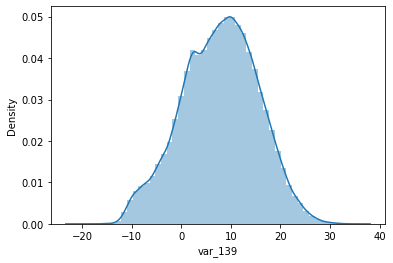

In [8]:
sns.distplot(y)

<AxesSubplot:xlabel='var_139', ylabel='Density'>

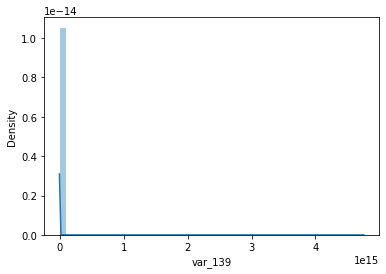

In [9]:
sns.distplot(y_exp)

In [10]:
y.describe()

count    200000.000000
mean          7.760193
std           7.686433
min         -21.274300
25%           2.387575
50%           8.066250
75%          13.232525
max          36.097100
Name: var_139, dtype: float64

In [11]:
y_exp.describe()  

count    2.000000e+05
mean     1.220843e+11
std      1.636058e+13
min     -1.000000e+00
25%      9.887061e+00
50%      3.184135e+03
75%      5.582283e+05
max      4.750850e+15
Name: var_139, dtype: float64

In [7]:
np.isinf(y_exp).sum()

0

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=777)
print('train : ', X_train.shape, '\t', 'test : ', X_valid.shape)

train :  (140000, 199) 	 test :  (60000, 199)


## Train

In [12]:
# Load Modules for EBM
from interpret.glassbox import ExplainableBoostingClassifier, ExplainableBoostingRegressor
from interpret import show
from interpret.perf import ROC, RegressionPerf
from interpret.data import ClassHistogram, Marginal

In [13]:
ebm = ExplainableBoostingRegressor()
ebm.fit(X_train, y_train)

ExplainableBoostingRegressor(feature_names=['var_0', 'var_1', 'var_2', 'var_3',
                                            'var_4', 'var_5', 'var_6', 'var_7',
                                            'var_8', 'var_9', 'var_10',
                                            'var_11', 'var_12', 'var_13',
                                            'var_14', 'var_15', 'var_16',
                                            'var_17', 'var_18', 'var_19',
                                            'var_20', 'var_21', 'var_22',
                                            'var_23', 'var_24', 'var_25',
                                            'var_26', 'var_27', 'var_28',
                                            'var_29', ...],
                             feature_types=['continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'con

In [14]:
joblib.dump(ebm,'01_07_ebm_var139_regression.pkl')

['01_07_ebm_var139_regression.pkl']

In [23]:
ebm = joblib.load('01_07_ebm_var139_regression.pkl')

## Predict

In [39]:
y_pred_tr = ebm.predict(X_train)
y_pred = ebm.predict(X_valid)

# df for result 
# y_score_tr = pd.DataFrame(data=y_score_tr).rename({0:'y_proba_0', 1:'y_proba_1'}, axis=1)
y_true_tr = pd.DataFrame(data=y_train).reset_index(drop=True).rename({'target':'y_true'}, axis=1)
y_pred_tr = pd.DataFrame(data=y_pred_tr).rename({0:'y_pred'}, axis=1)
df_pred_tr_summary = pd.concat([y_true_tr,y_pred_tr], axis=1)
# df_pred_tr_summary = pd.concat([y_score_tr,y_true_tr,y_pred_tr], axis=1)

# y_score = pd.DataFrame(data=y_score).rename({0:'y_proba_0', 1:'y_proba_1'}, axis=1)
y_true = pd.DataFrame(data=y_valid).reset_index(drop=True).rename({'target':'y_true'}, axis=1)
y_pred = pd.DataFrame(data=y_pred).rename({0:'y_pred'}, axis=1)
df_pred_summary = pd.concat([y_true,y_pred], axis=1)
# df_pred_summary = pd.concat([y_score,y_true,y_pred], axis=1)

In [40]:
y_pred

y_pred
0      7.807966
1      7.799652
2      7.886866
3      7.782765
4      7.477053
...         ...
59995  7.740600
59996  7.460448
59997  7.865131
59998  7.863867
59999  7.880280

[60000 rows x 1 columns]

In [24]:
# Predict train set
# y_pred_tr = ebm.predict(X_train)
# y_score_tr = ebm.predict_proba(X_train)
ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_valid, y_valid, name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7812/140570096392272/ -->

In [25]:
ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_train, y_train, name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7812/140570096393664/ -->

# Evaluation

In [42]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_true, y_pred))
rmse

7.696909165407817

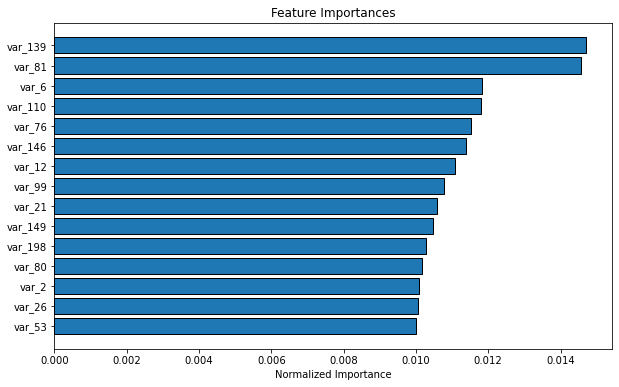

index           feature  importance  importance_normalized
0      139           var_139    0.176795               0.014701
1       81            var_81    0.175144               0.014564
2        6             var_6    0.142383               0.011839
3      110           var_110    0.141768               0.011788
4       76            var_76    0.138418               0.011510
..     ...               ...         ...                    ...
205      7             var_7    0.010204               0.000848
206    201  var_81 x var_184    0.008366               0.000696
207    202   var_40 x var_78    0.008332               0.000693
208     96            var_96    0.008291               0.000689
209    203  var_81 x var_164    0.006856               0.000570

[210 rows x 4 columns]

In [117]:
####### 원래 EBM 결과 피쳐중요도 (비교!)
plot_feature_importances(df_feature_importance)

# Interpret

In [15]:
# ebm.feature_importance_ 결과와 동일
ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7812/140574076246336/ -->

In [16]:
ebm_local = ebm.explain_local(X_valid, y_valid)
show(ebm_local)

<!-- http://127.0.0.1:7812/140572157881696/ -->

In [17]:
ebm_local_smp = ebm.explain_local(X_valid[:5], y_valid[:5])
show(ebm_local_smp)

<!-- http://127.0.0.1:7812/140571259014256/ -->

In [ ]:
ebm_local = ebm.explain_local(x_valid[:5], y_valid[:5], name='EBM')
show(ebm_local)

# EBM Modeling - with y = exponential var_139

## Prepare dataset for modeling

In [6]:
# X_proc = df_train_proc.drop(['target'], axis=1)
# y_proc = df_train_proc['target']

In [21]:
X = df_train.drop(['ID_code', 'target', 'var_139'], axis=1)
y = df_train['var_139']
y_exp = np.expm1(df_train['var_139'])

In [ ]:
# X_exp_proc = np.exp(X_proc)
# X_expm1_proc = np.expm1(X_proc)
# X_exp_proc

In [18]:
X_train, X_valid, y_train_exp, y_valid_exp = train_test_split(X, y_exp, test_size=0.3, random_state=777)
print('train : ', X_train.shape, '\t', 'test : ', X_valid.shape)

train :  (140000, 199) 	 test :  (60000, 199)


## Train

In [19]:
ebm = ExplainableBoostingRegressor()
ebm.fit(X_train, y_train_exp)

ExplainableBoostingRegressor(feature_names=['var_0', 'var_1', 'var_2', 'var_3',
                                            'var_4', 'var_5', 'var_6', 'var_7',
                                            'var_8', 'var_9', 'var_10',
                                            'var_11', 'var_12', 'var_13',
                                            'var_14', 'var_15', 'var_16',
                                            'var_17', 'var_18', 'var_19',
                                            'var_20', 'var_21', 'var_22',
                                            'var_23', 'var_24', 'var_25',
                                            'var_26', 'var_27', 'var_28',
                                            'var_29', ...],
                             feature_types=['continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'con

In [20]:
joblib.dump(ebm,'01_07_ebm_exp_var139_regression.pkl')

['01_07_ebm_exp_var139_regression.pkl']

In [26]:
ebm_exp = joblib.load('01_07_ebm_exp_var139_regression.pkl')

## Predict

In [23]:
ebm_exp.predict(X_valid)

array([-3.53770377e+10, -3.61541424e+10,  1.33650805e+11, ...,
        5.51166038e+10, -4.66792950e+10,  3.73002345e+10])

In [24]:
ebm_perf = RegressionPerf(ebm_exp.predict).explain_perf(X_valid, y_valid, name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7623/140661888138688/ -->

In [25]:
ebm_perf = RegressionPerf(ebm_exp.predict).explain_perf(X_train, y_train, name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7623/140661177810848/ -->

In [33]:
# Predict train set
y_pred_tr = ebm_exp.predict(X_train)
# y_score_tr = ebm.predict_proba(X_train)

In [34]:
# Predict Valid set
y_pred = ebm_exp.predict(X_valid)
# y_score = ebm.predict_proba(X_valid)

In [35]:
# df for result 
# y_score_tr = pd.DataFrame(data=y_score_tr).rename({0:'y_proba_0', 1:'y_proba_1'}, axis=1)
y_true_tr = pd.DataFrame(data=y_train).reset_index(drop=True).rename({'target':'y_true'}, axis=1)
y_pred_tr = pd.DataFrame(data=y_pred_tr).rename({0:'y_pred'}, axis=1)
df_pred_tr_summary = pd.concat([y_true_tr,y_pred_tr], axis=1)
# df_pred_tr_summary = pd.concat([y_score_tr,y_true_tr,y_pred_tr], axis=1)

# y_score = pd.DataFrame(data=y_score).rename({0:'y_proba_0', 1:'y_proba_1'}, axis=1)
y_true = pd.DataFrame(data=y_valid).reset_index(drop=True).rename({'target':'y_true'}, axis=1)
y_pred = pd.DataFrame(data=y_pred).rename({0:'y_pred'}, axis=1)
df_pred_summary = pd.concat([y_true,y_pred], axis=1)
# df_pred_summary = pd.concat([y_score,y_true,y_pred], axis=1)

In [36]:
len(df_pred_tr_summary)

140000

In [37]:
df_pred_summary.head(3)

var_139        y_pred
0  17.6534 -3.537704e+10
1  -6.5720 -3.615414e+10
2  15.0973  1.336508e+11

# Evaluation

In [38]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_true, y_pred))
rmse

844160588836.2288

In [47]:
ebm.global_selector

[1447903146.6104546,
 1323074173.8850617,
 1447702040.5805798,
 2071508097.3573134,
 1926076259.6877646,
 2294221889.723184,
 1795770910.0678213,
 1526477418.025842,
 1525007947.9838629,
 1817258235.6260982,
 2036847345.4587557,
 2145972331.0082705,
 1370686623.2454977,
 2222391330.8439994,
 1446733678.096198,
 2775222843.332413,
 1963675307.5423706,
 1422537445.605285,
 1419211134.9594567,
 1280337130.4915173,
 1338967353.8472593,
 1453631267.151374,
 1177502278.2956786,
 1047357254.4895558,
 1839958984.0327551,
 1582859752.883678,
 1695474402.9131045,
 1052693211.9875598,
 1230439180.918245,
 1194856830.0285997,
 1517181920.81981,
 1780061980.0040214,
 1583595666.434848,
 1568043862.2236295,
 1184246287.1728532,
 1880491533.183711,
 1600572504.2066417,
 1440121895.8814578,
 1523426710.7627006,
 1009569754.1418277,
 900484107.6595112,
 1369024377.9440236,
 1613296798.4442852,
 1115572527.226744,
 1784292934.8474195,
 1588769047.138719,
 1568512383.3352723,
 992649739.0314887,
 1470654

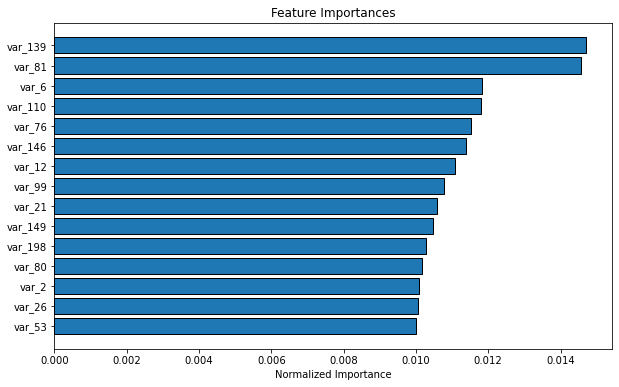

index           feature  importance  importance_normalized
0      139           var_139    0.176795               0.014701
1       81            var_81    0.175144               0.014564
2        6             var_6    0.142383               0.011839
3      110           var_110    0.141768               0.011788
4       76            var_76    0.138418               0.011510
..     ...               ...         ...                    ...
205      7             var_7    0.010204               0.000848
206    201  var_81 x var_184    0.008366               0.000696
207    202   var_40 x var_78    0.008332               0.000693
208     96            var_96    0.008291               0.000689
209    203  var_81 x var_164    0.006856               0.000570

[210 rows x 4 columns]

In [117]:
plot_feature_importances(df_feature_importance)

# Interpret

In [48]:
# ebm.feature_importance_ 결과와 동일
ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7390/140271421881744/ -->

In [50]:
# ebm_local = ebm.explain_local(X_valid, y_valid)
# show(ebm_local)

In [51]:
ebm_local_smp = ebm.explain_local(X_valid[:5], y_valid[:5])
show(ebm_local_smp)

<!-- http://127.0.0.1:7390/140270137392240/ -->

In [ ]:
ebm_local = ebm.explain_local(x_valid[:5], y_valid[:5], name='EBM')
show(ebm_local)